<a href="https://colab.research.google.com/github/AmyHumke12/SolarProject/blob/main/IPTV_SolarProduction_Pre_Processing_Transformations_Step_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 4 of preprocesng
- This notebook will begin looking at transformations and interaction fields to further explore potential predictive models
- XGB Test cNMAE score of 14.25% is the number to beat at the start of this notebook

In [ ]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
#Requirements
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import pickle
from itertools import combinations
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

# Ensure inline plotting in Jupyter notebooks or Google Colab
%matplotlib inline


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


#Load Data

In [ ]:
# Specify the file paths where the pickle files are saved
train_df_path = '/content/drive/My Drive/train_df.pkl'
test_df_path = '/content/drive/My Drive/test_df.pkl'

# Load the DataFrames from the pickle files
train_df = pd.read_pickle(train_df_path)
print("train_df has been loaded successfully.")

test_df = pd.read_pickle(test_df_path)
print("test_df has been loaded successfully.")


train_df has been loaded successfully.
test_df has been loaded successfully.


#Drop the weather fields

In [ ]:
# List of fields to drop
fields_to_drop = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'precipitation',
    'snow_depth', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid',
    'cloud_cover_high', 'wind_speed_10m', 'wind_gusts_10m', 'sunshine_duration'
]

# Drop the fields from train_df and test_df
train_df = train_df.drop(columns=fields_to_drop, errors='ignore')
test_df = test_df.drop(columns=fields_to_drop, errors='ignore')

# Confirm the fields have been removed
print("Updated train_df columns:")
print(train_df.columns)

print("\nUpdated test_df columns:")
print(test_df.columns)


Updated train_df columns:
Index(['date', 'month', 'day_of_month', 'hour', 'is_daylight', 'solar_angle',
       'solar_azimuth', 'global_tilted_irradiance', 'value', 'solar_day_count',
       'Estimated_Area_Solar_Production'],
      dtype='object')

Updated test_df columns:
Index(['date', 'month', 'day_of_month', 'hour', 'is_daylight', 'solar_angle',
       'solar_azimuth', 'global_tilted_irradiance', 'value', 'solar_day_count',
       'Estimated_Area_Solar_Production'],
      dtype='object')


#Create the corrected_estimate field

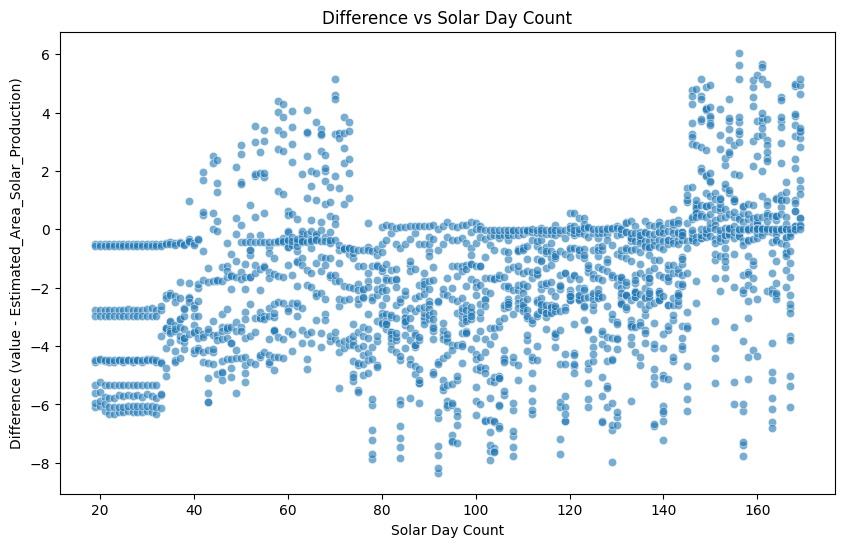

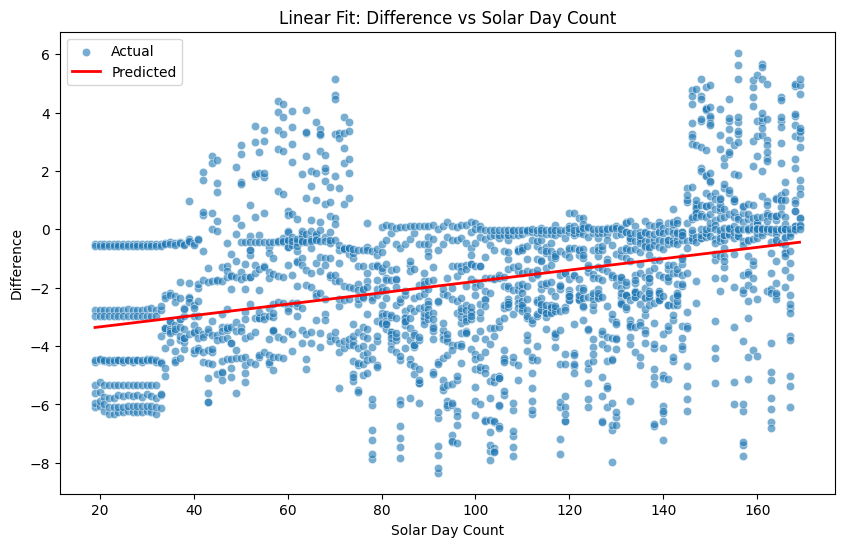

R² of the linear regression: 0.107


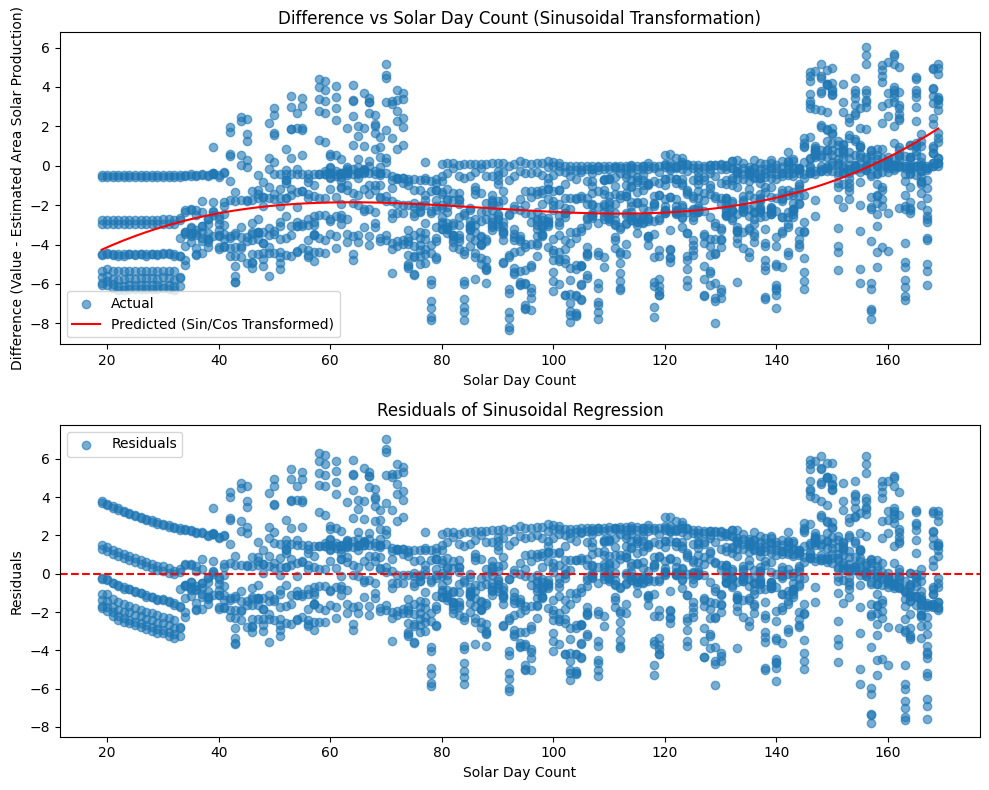

R² of the sinusoidal transformation regression: 0.199
          value  Estimated_Area_Solar_Production  corrected_estimate
0  1.000000e-10                            0.494            -3.77012
1  1.000000e-10                            2.773            -1.49112
2  2.300000e-02                            4.560             0.29588
3  1.560000e-01                            5.780             1.51588
4  2.400000e-01                            6.316             2.05188
      Estimated_Area_Solar_Production  corrected_estimate
1953                            0.149             2.41905
1954                            1.502             3.77205
1955                            3.674             5.94405
1956                            5.494             7.76405
1957                            6.983             9.25305


In [ ]:
# Step 1.1: Calculate the difference in the training set
train_df['difference'] = train_df['value'] - train_df['Estimated_Area_Solar_Production']

# Step 1.2: Plot the difference vs. solar_day_count
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['solar_day_count'], y=train_df['difference'], alpha=0.6)
plt.title("Difference vs Solar Day Count")
plt.xlabel("Solar Day Count")
plt.ylabel("Difference (value - Estimated_Area_Solar_Production)")
plt.show()

# Step 1.3: Fit a linear regression model to assess the relationship
solar_day_count = train_df[['solar_day_count']].values.reshape(-1, 1)
difference = train_df['difference'].values.reshape(-1, 1)

linear_model = LinearRegression()
linear_model.fit(solar_day_count, difference)

# Predict the difference using the regression model
predicted_difference = linear_model.predict(solar_day_count)

# Plot regression fit
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['solar_day_count'], y=train_df['difference'], alpha=0.6, label="Actual")
plt.plot(train_df['solar_day_count'], predicted_difference, color="red", label="Predicted", linewidth=2)
plt.title("Linear Fit: Difference vs Solar Day Count")
plt.xlabel("Solar Day Count")
plt.ylabel("Difference")
plt.legend()
plt.show()

# Step 1.4: Assess the goodness of fit
r2 = r2_score(difference, predicted_difference)
print(f"R² of the linear regression: {r2:.3f}")

# Step 2.1: Apply a sinusoidal transformation (adjusted for hourly data)
train_df['sin_transformed'] = np.sin(2 * np.pi * train_df['solar_day_count'] / 8766)
train_df['cos_transformed'] = np.cos(2 * np.pi * train_df['solar_day_count'] / 8766)

# Prepare the transformed features for regression
X_transformed = train_df[['solar_day_count', 'sin_transformed', 'cos_transformed']]
y_difference = train_df['value'] - train_df['Estimated_Area_Solar_Production']

# Fit a linear regression model
regressor = LinearRegression()
regressor.fit(X_transformed, y_difference)

# Predict differences using the sinusoidal features
y_pred_transformed = regressor.predict(X_transformed)

# Calculate the R² value
r2_transformed = r2_score(y_difference, y_pred_transformed)

# Plot the actual vs predicted differences
plt.figure(figsize=(10, 8))

# Scatter plot of actual differences
plt.subplot(2, 1, 1)
plt.scatter(train_df['solar_day_count'], y_difference, alpha=0.6, label="Actual")
plt.plot(train_df['solar_day_count'], y_pred_transformed, color='red', label="Predicted (Sin/Cos Transformed)")
plt.xlabel("Solar Day Count")
plt.ylabel("Difference (Value - Estimated Area Solar Production)")
plt.title("Difference vs Solar Day Count (Sinusoidal Transformation)")
plt.legend()

# Residuals plot
plt.subplot(2, 1, 2)
plt.scatter(train_df['solar_day_count'], y_difference - y_pred_transformed, alpha=0.6, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Solar Day Count")
plt.ylabel("Residuals")
plt.title("Residuals of Sinusoidal Regression")
plt.legend()

plt.tight_layout()
plt.show()

# Print the R² value
print(f"R² of the sinusoidal transformation regression: {r2_transformed:.3f}")

# Step 3: Drop unnecessary columns from train_df and test_df
columns_to_drop = ['difference', 'month_day', 'month_day_encoded']
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
test_df = test_df.drop(columns=columns_to_drop, errors='ignore')

# Apply the sinusoidal transformation to train_df and test_df
train_df['sin_transformed'] = np.sin(2 * np.pi * train_df['solar_day_count'] / 8766)
train_df['cos_transformed'] = np.cos(2 * np.pi * train_df['solar_day_count'] / 8766)

test_df['sin_transformed'] = np.sin(2 * np.pi * test_df['solar_day_count'] / 8766)
test_df['cos_transformed'] = np.cos(2 * np.pi * test_df['solar_day_count'] / 8766)

# Use the trained regression model to predict the differences
train_features = train_df[['solar_day_count', 'sin_transformed', 'cos_transformed']]
test_features = test_df[['solar_day_count', 'sin_transformed', 'cos_transformed']]

# Predict the differences for train and test sets
train_df['predicted_difference'] = regressor.predict(train_features)
test_df['predicted_difference'] = regressor.predict(test_features)

# Compute the corrected estimate
train_df['corrected_estimate'] = train_df['Estimated_Area_Solar_Production'] + train_df['predicted_difference']
test_df['corrected_estimate'] = test_df['Estimated_Area_Solar_Production'] + test_df['predicted_difference']

# Drop temporary columns if necessary
columns_to_cleanup = ['sin_transformed', 'cos_transformed', 'predicted_difference']
train_df = train_df.drop(columns=columns_to_cleanup, errors='ignore')
test_df = test_df.drop(columns=columns_to_cleanup, errors='ignore')

# Verify the new corrected_estimate
print(train_df[['value', 'Estimated_Area_Solar_Production', 'corrected_estimate']].head())
print(test_df[['Estimated_Area_Solar_Production', 'corrected_estimate']].head())


#Scale Quantitative Fields

In [ ]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, 0 to 1936
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             1937 non-null   datetime64[ns]
 1   month                            1937 non-null   int32         
 2   day_of_month                     1937 non-null   int32         
 3   hour                             1937 non-null   int32         
 4   is_daylight                      1937 non-null   int64         
 5   solar_angle                      1937 non-null   float64       
 6   solar_azimuth                    1937 non-null   float64       
 7   global_tilted_irradiance         1937 non-null   float32       
 8   value                            1937 non-null   float64       
 9   solar_day_count                  1937 non-null   int64         
 10  Estimated_Area_Solar_Production  1937 non-null   float64       
 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# List of columns to scale
columns_to_scale = [
    'solar_angle', 'solar_azimuth',
    'global_tilted_irradiance', 'solar_day_count', 'Estimated_Area_Solar_Production',
    'corrected_estimate'
]

# Verify all columns exist in train_df and test_df
missing_columns_train = [col for col in columns_to_scale if col not in train_df.columns]
missing_columns_test = [col for col in columns_to_scale if col not in test_df.columns]

if missing_columns_train or missing_columns_test:
    raise ValueError(f"Missing columns in train_df: {missing_columns_train}, test_df: {missing_columns_test}")

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(train_df[columns_to_scale])

# Scale and assign back to DataFrames
train_df.loc[:, columns_to_scale] = scaler.transform(train_df[columns_to_scale])
test_df.loc[:, columns_to_scale] = scaler.transform(test_df[columns_to_scale])

# Convert to float32 to match original dtypes (optional)
train_df[columns_to_scale] = train_df[columns_to_scale].astype('float32')
test_df[columns_to_scale] = test_df[columns_to_scale].astype('float32')

# Display the first few rows to verify scaling
print("Scaled Train DataFrame:")
print(train_df.head())

print("\nScaled Test DataFrame:")
print(test_df.head())


Scaled Train DataFrame:
                 date  month  day_of_month  hour  is_daylight  solar_angle  \
0 2024-01-09 07:00:00      1             9     7            1     0.063489   
1 2024-01-09 08:00:00      1             9     8            1     0.183268   
2 2024-01-09 09:00:00      1             9     9            1     0.285428   
3 2024-01-09 10:00:00      1             9    10            1     0.366623   
4 2024-01-09 11:00:00      1             9    11            1     0.419244   

   solar_azimuth  global_tilted_irradiance         value  solar_day_count  \
0       0.252971                  0.000000  1.000000e-10              0.0   
1       0.294760                  0.008545  1.000000e-10              0.0   
2       0.341393                  0.058866  2.300000e-02              0.0   
3       0.394112                  0.113935  1.560000e-01              0.0   
4       0.452846                  0.193647  2.400000e-01              0.0   

   Estimated_Area_Solar_Production  correcte

<ipython-input-115-9c7ee6b2f94e>:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.0085451  0.05886625 ... 0.34449662 0.19785655 0.01051049]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  train_df.loc[:, columns_to_scale] = scaler.transform(train_df[columns_to_scale])
<ipython-input-115-9c7ee6b2f94e>:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 1. 1. 1.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[:, columns_to_scale] = scaler.transform(train_df[columns_to_scale])
<ipython-input-115-9c7ee6b2f94e>:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0095752  0.06689199 0.10745943 ... 0.48057407 0.47445863 0.23068291]' has dtype incompatible

##Pickle the scaler to be picked up in production notebook later assuming it is used

In [ ]:
# Specify the file path where you want to save the scaler pickle file
scaler_path = '/content/drive/My Drive/minmax_scaler.pkl'

# Save the fitted scaler as a pickle file
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

print(f"MinMaxScaler has been saved to {scaler_path}")



MinMaxScaler has been saved to /content/drive/My Drive/minmax_scaler.pkl


#Look at variables relationship to the target

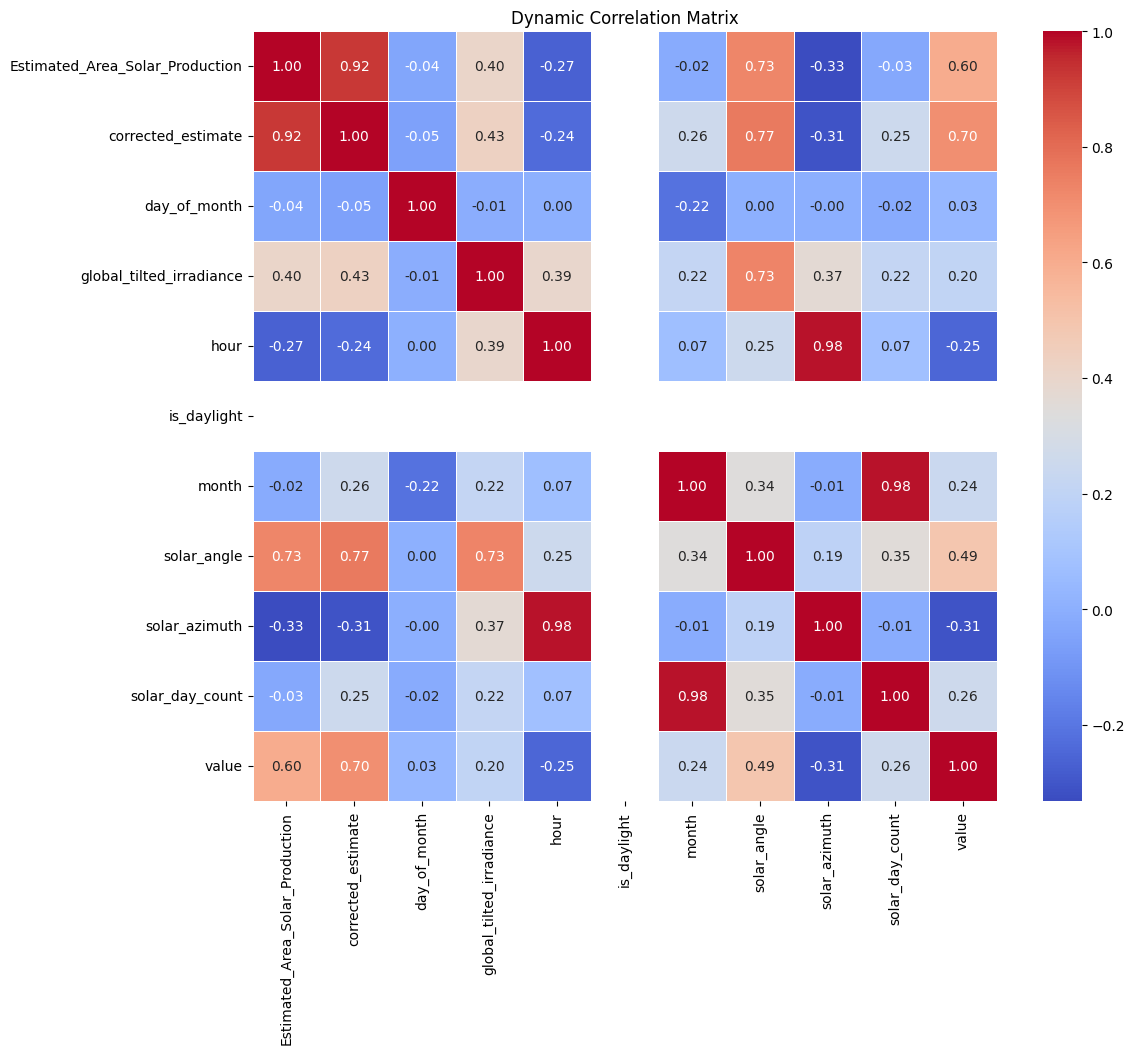

Correlation of each variable with the target 'value' (sorted by absolute value):
value                              1.000000
corrected_estimate                 0.702557
Estimated_Area_Solar_Production    0.603982
solar_angle                        0.494505
solar_azimuth                     -0.309449
solar_day_count                    0.257168
hour                              -0.254169
month                              0.242494
global_tilted_irradiance           0.203883
day_of_month                       0.034383
is_daylight                             NaN
Name: value, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dynamically select columns to include in the correlation matrix
# Exclude columns like 'date' and 'month' (non-numeric or less relevant)
columns_to_exclude = ['ds']
columns_to_include = train_df.select_dtypes(include=[float, int]).columns.difference(columns_to_exclude)

# Calculate the correlation matrix
correlation_matrix = train_df[columns_to_include].corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))  # Adjust size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Dynamic Correlation Matrix')
plt.show()

# Print out the correlation of each variable with the target 'value', sorted by absolute value
if 'value' in correlation_matrix.columns:
    target_correlation = correlation_matrix['value']
    target_correlation_sorted = target_correlation.reindex(target_correlation.abs().sort_values(ascending=False).index)

    print("Correlation of each variable with the target 'value' (sorted by absolute value):")
    print(target_correlation_sorted)
else:
    print("Target 'value' not found in the correlation matrix columns.")


##Key Observations from Updated Correlation Analysis
###High Correlation with Target (value):

- corrected_estimate (0.70) and Estimated_Area_Solar_Production (0.60) are the most predictive features.
- solar_angle (0.49), solar_day_count (0.26), and solar_azimuth (-0.31) remain key predictors of solar production, representing positional and seasonal characteristics of the solar system.

###Seasonal Features and Solar Characteristics:

- solar_angle (0.49) highlights the importance of the sun's position in determining solar production.
- month (0.24) and solar_day_count (0.26) show weaker correlations than expected but still reflect seasonal and temporal patterns impacting solar energy generation.

###Meteorological Factors:

- global_tilted_irradiance (0.20) has a moderate positive correlation with the target, indicating its relevance in capturing solar energy availability.
Other meteorological variables, such as is_daylight and hourly features, do not show a strong direct relationship with the target value.

###Moderate and Weak Correlations:

- hour (-0.25) displays a moderate negative correlation with the target, reflecting the diurnal cycle of solar production.
day_of_month (0.03) and is_daylight (not available) show very weak correlations, indicating limited direct influence on solar production predictions.
Least Correlated Features:

- month (0.24) has a low correlation, reflecting reduced seasonal variability due to hourly granularity compared to daily aggregates.
Other features such as global_tilted_irradiance (0.20) and day_of_month (0.03) may not independently add significant predictive value.

#Scatter plots for individual fields and value

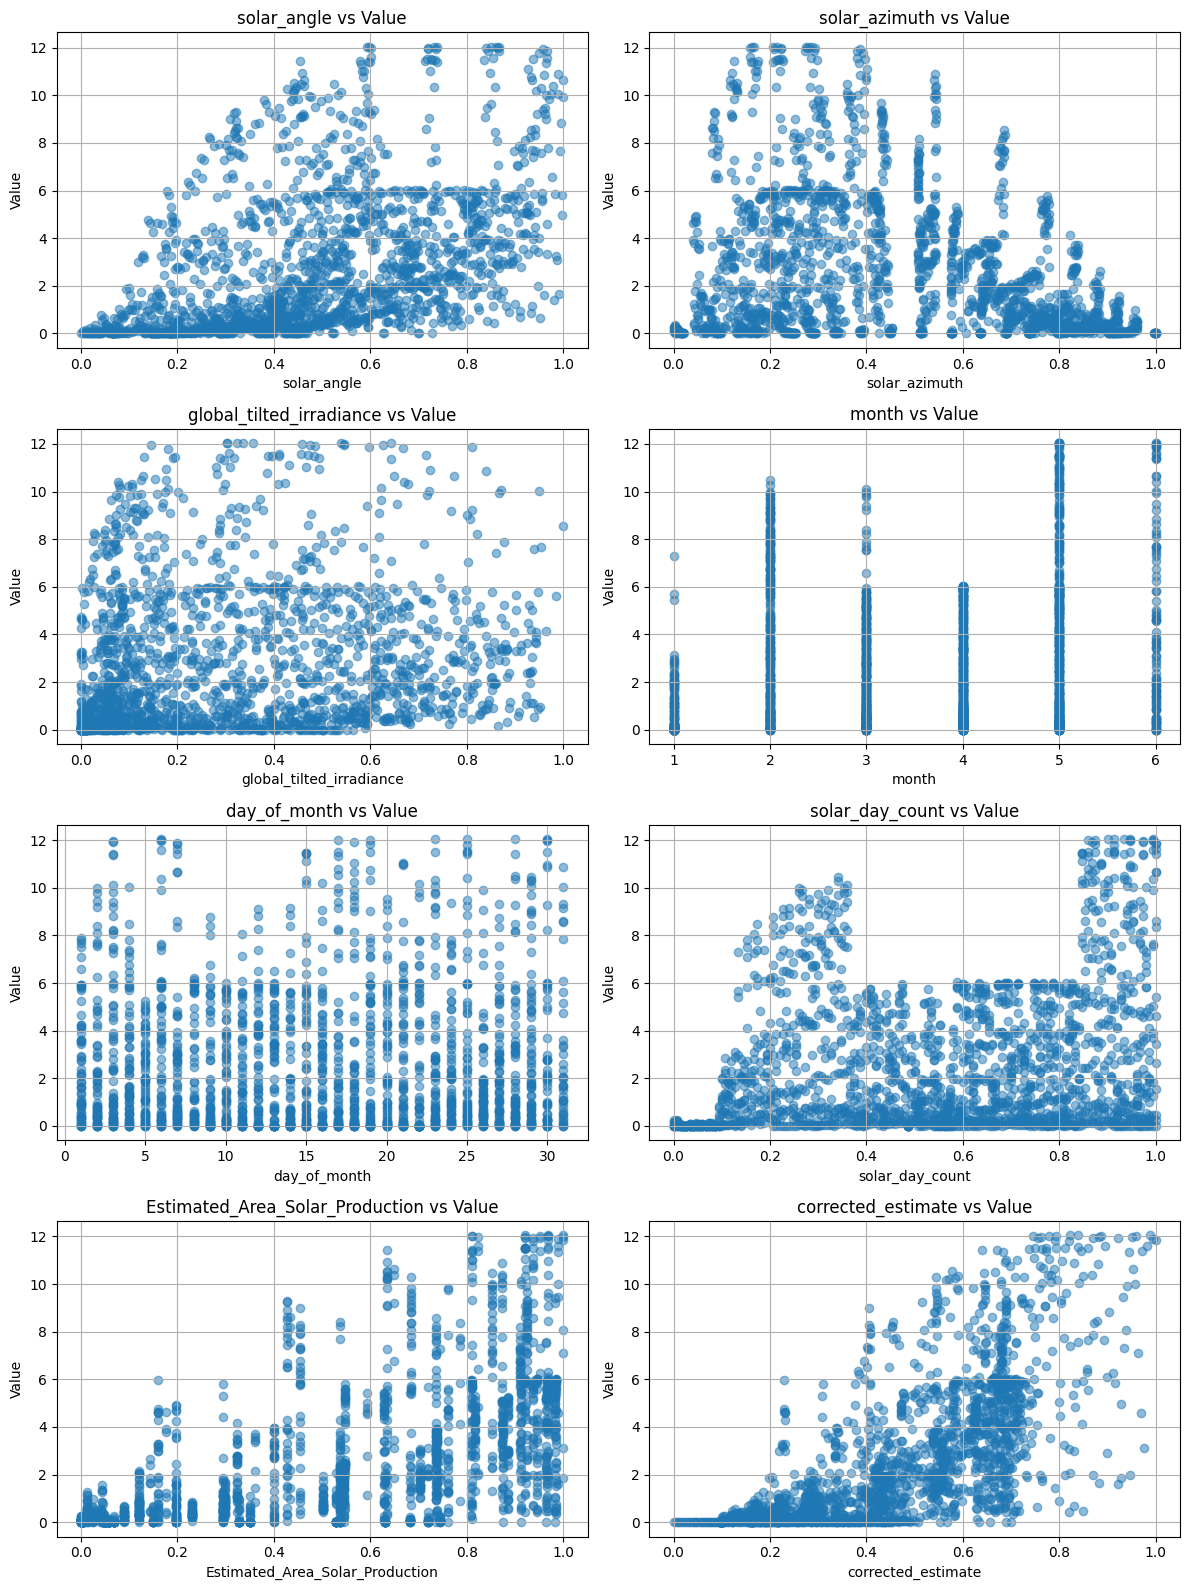

In [ ]:
# Define the columns to plot
columns_to_plot = [
    'solar_angle', 'solar_azimuth',
    'global_tilted_irradiance','month', 'day_of_month', 'solar_day_count','Estimated_Area_Solar_Production', 'corrected_estimate'
]

# Determine the layout: 2 columns, calculate rows based on number of features
n_columns = 2
n_rows = len(columns_to_plot) // n_columns + (len(columns_to_plot) % n_columns > 0)

# Create a figure with the specified layout
plt.figure(figsize=(12, n_rows * 4))

# Generate a scatter plot for each column
for i, column in enumerate(columns_to_plot):
    plt.subplot(n_rows, n_columns, i + 1)
    plt.scatter(train_df[column], train_df['value'], alpha=0.5)
    plt.title(f'{column} vs Value')
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Key Observations

The scatter plots provide detailed insights into the relationships between features and `value`:

- **Strong Positive Relationships**:
  - **`corrected_estimate` and `value`**: The scatter plot shows a strong positive relationship, reinforcing its importance in predicting solar production.
  - **`Estimated_Area_Solar_Production` and `value`**: A moderately positive trend is visible, but its predictive power might be slightly less compared to `corrected_estimate`.

- **Seasonal and Positional Features**:
  - **`solar_angle`** and **`solar_day_count`** show clear seasonal patterns, with higher values corresponding to greater solar production. These variables effectively capture positional and temporal solar dynamics.
  - **`solar_azimuth`** has a less distinct trend but still correlates to solar production variability.

- **Moderate Meteorological Influence**:
  - **`global_tilted_irradiance`** displays a moderate positive relationship with `value`, highlighting its contribution to solar energy availability.
  - **`month`** shows cyclical behavior, reflecting seasonal trends in solar production.

- **Weak Relationships**:
  - **`day_of_month`** exhibits no clear relationship with `value`, suggesting it might be less critical as a standalone feature.

---

# Recommendations for Feature Engineering

### **1. Focus on High-Correlation Features**:
- Retain and prioritize features like **`corrected_estimate`**, **`Estimated_Area_Solar_Production`**, **`solar_angle`**, and **`solar_day_count`**, as these exhibit strong and meaningful trends with `value`.
- Include **`global_tilted_irradiance`** for its moderate yet consistent impact on solar production.

### **2. Transform Temporal Features**:
- Apply **cyclic transformations (sin and cos)** for features like **`month`** and **`solar_day_count`** to better capture seasonality and cyclical patterns.

### **3. Refine or Exclude Low-Impact Features**:
- Features such as **`day_of_month`** can be excluded or aggregated, as they show minimal correlation with `value`.

### **4. Explore Polynomial or Interaction Terms**:
- Investigate **polynomial transformations** for `solar_angle` and `solar_day_count` to enhance their representation of non-linear patterns.
- Evaluate **interaction terms** (e.g., between `solar_angle` and `global_tilted_irradiance`) to account for combined effects on solar production.

#Feature Transformations

##Temporal Transformations of month and solar_day_count

In [ ]:
# Function to apply sinusoidal transformations
def apply_temporal_transformations(df, temporal_columns):
    """
    Apply sinusoidal transformations to temporal features (e.g., month, solar_day_count).

    :param df: DataFrame containing the features.
    :param temporal_columns: List of temporal columns to transform. Each element should be a tuple of (column_name, period).
                             For example: [("month", 12), ("solar_day_count", 365)]
    :return: DataFrame with added sinusoidal features.
    """
    for column, period in temporal_columns:
        df[f"{column}_sin"] = np.sin(2 * np.pi * df[column] / period)
        df[f"{column}_cos"] = np.cos(2 * np.pi * df[column] / period)
    return df

temporal_columns = [("month", 12), ("solar_day_count", 365)]

# Apply transformations to train and test datasets
train_df = apply_temporal_transformations(train_df, temporal_columns)
test_df = apply_temporal_transformations(test_df, temporal_columns)

# Inspect the transformed DataFrame
print(train_df[["month", "month_sin", "month_cos", "solar_day_count", "solar_day_count_sin", "solar_day_count_cos"]].head())


   month  month_sin  month_cos  solar_day_count  solar_day_count_sin  \
0      1        0.5   0.866025              0.0                  0.0   
1      1        0.5   0.866025              0.0                  0.0   
2      1        0.5   0.866025              0.0                  0.0   
3      1        0.5   0.866025              0.0                  0.0   
4      1        0.5   0.866025              0.0                  0.0   

   solar_day_count_cos  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  


##Solar Angle

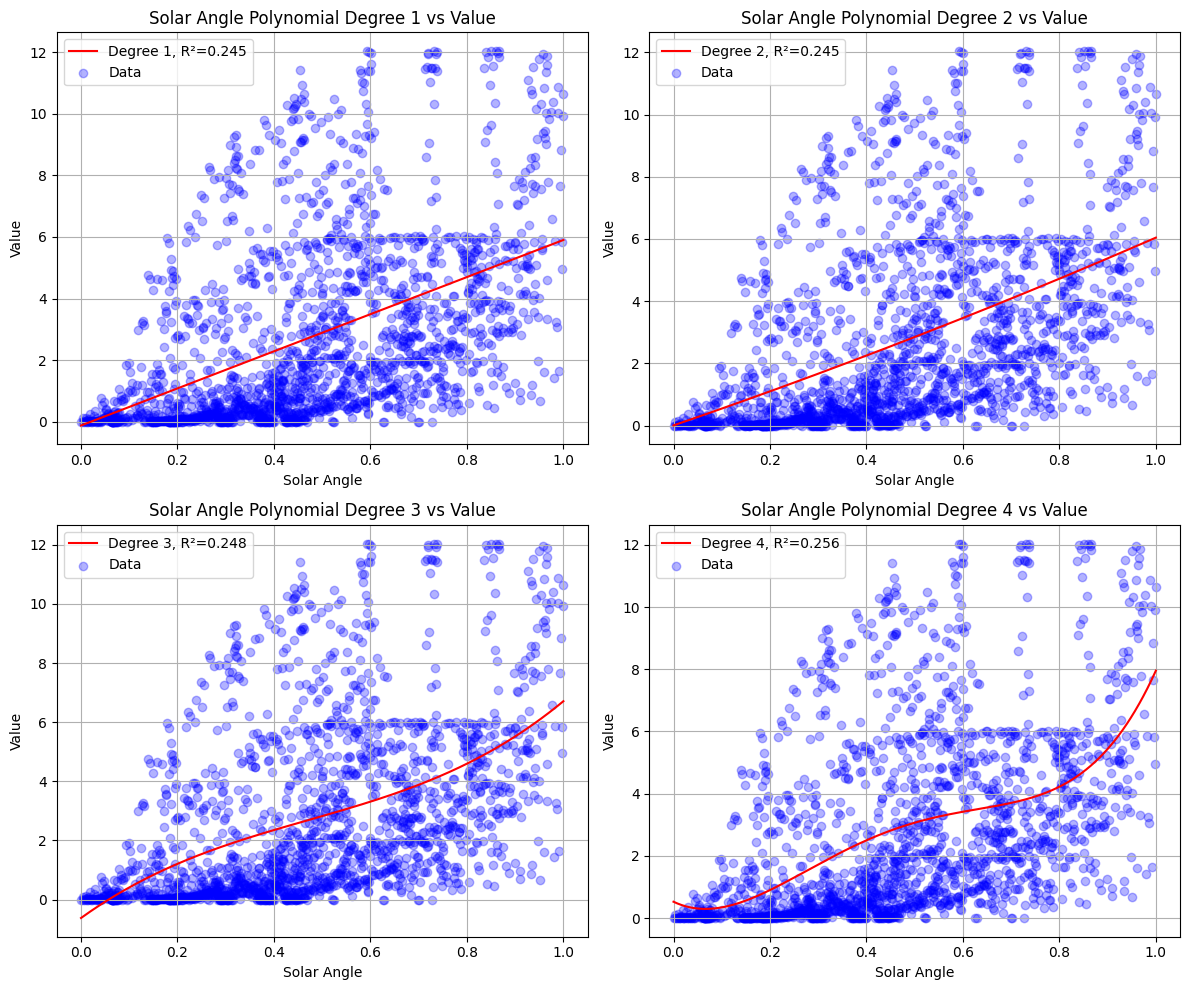

In [ ]:
# Prepare polynomial features for solar_angle
solar_angle = train_df['solar_angle'].values.reshape(-1, 1)
value = train_df['value'].values

# Define degrees to explore
degrees = [1, 2, 3, 4]

# Sort solar_angle and value by solar_angle for better visualization
sorted_indices = np.argsort(solar_angle, axis=0).flatten()
solar_angle_sorted = solar_angle[sorted_indices]
value_sorted = value[sorted_indices]

# Create subplots for visual comparison
plt.figure(figsize=(12, 10))

for i, degree in enumerate(degrees):
    poly = PolynomialFeatures(degree=degree)
    solar_angle_poly = poly.fit_transform(solar_angle_sorted)

    # Fit a linear model on the transformed features
    model = LinearRegression().fit(solar_angle_poly, value_sorted)
    value_pred = model.predict(solar_angle_poly)

    # Calculate R-squared
    r2 = r2_score(value_sorted, value_pred)

    # Plot the polynomial fit
    plt.subplot(2, 2, i + 1)
    plt.plot(solar_angle_sorted, value_pred, color='red', label=f'Degree {degree}, R²={r2:.3f}')
    plt.scatter(solar_angle_sorted, value_sorted, alpha=0.3, label='Data', color='blue')
    plt.title(f'Solar Angle Polynomial Degree {degree} vs Value')
    plt.xlabel('Solar Angle')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


The analysis compares polynomial fits of degrees 1 through 4 for the relationship between solar_angle and value. The R² values range from 0.245 (linear) to 0.256 (quartic), with minimal improvement as complexity increases. The degree 1 linear fit captures the trend effectively with simplicity, while higher-degree polynomials offer negligible gains and risk overfitting. For practical purposes, the linear fit is recommended, but the quartic fit could be considered if additional non-linear complexity is needed and validated for generalizability.

##Global Tilted Irradiance
-Skipping this due to low R2

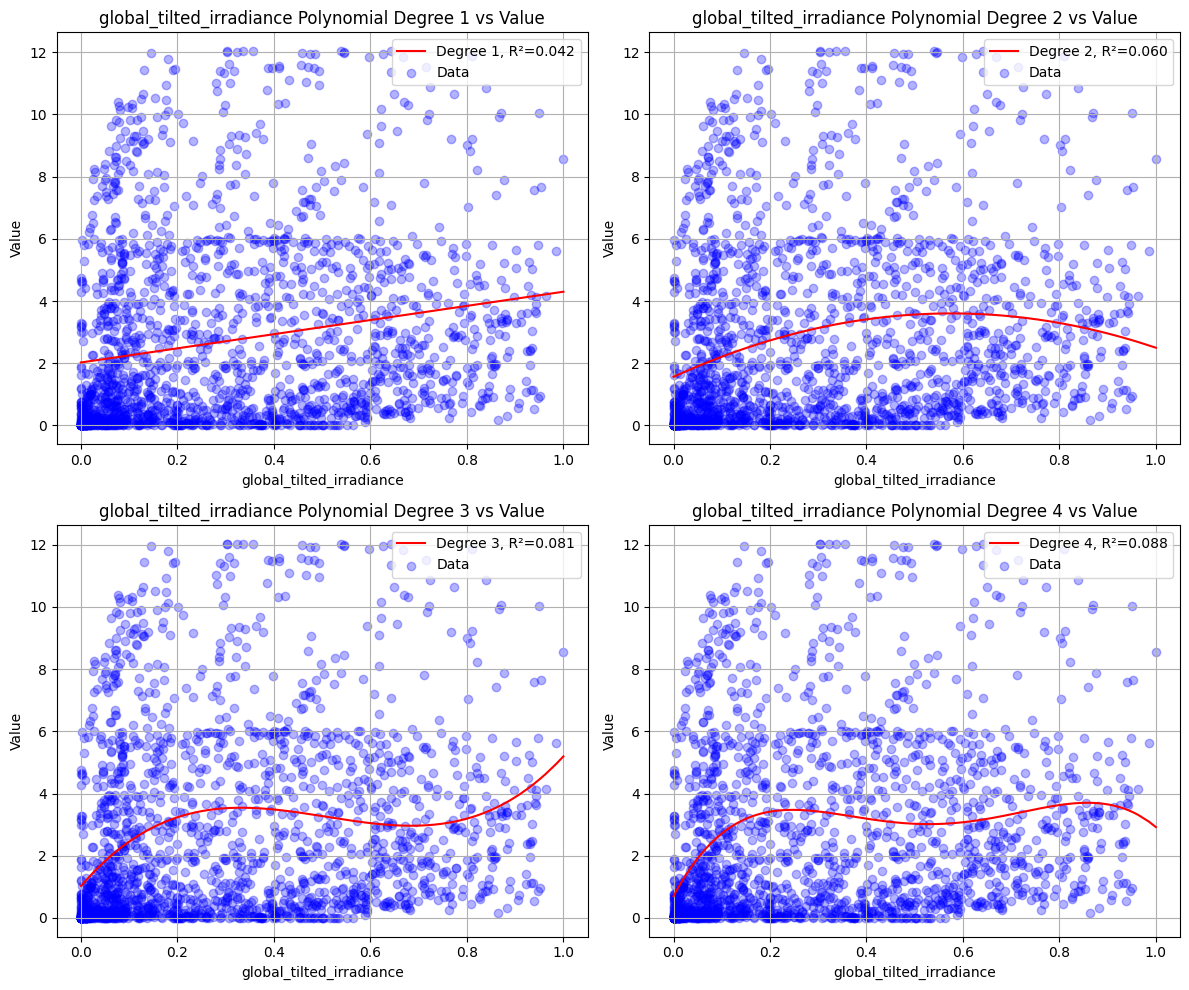

In [ ]:
# Prepare polynomial features for global_tilted_irradiance
global_tilted_irradiance = train_df['global_tilted_irradiance'].values.reshape(-1, 1)
value = train_df['value'].values

# Define degrees to explore
degrees = [1, 2, 3, 4]

# Sort global_tilted_irradiance and value by global_tilted_irradiance for better visualization
sorted_indices = np.argsort(global_tilted_irradiance, axis=0).flatten()
global_tilted_irradiance_sorted = global_tilted_irradiance[sorted_indices]
value_sorted = value[sorted_indices]

# Create subplots for visual comparison
plt.figure(figsize=(12, 10))

for i, degree in enumerate(degrees):
    poly = PolynomialFeatures(degree=degree)
    global_tilted_irradiance_poly = poly.fit_transform(global_tilted_irradiance_sorted)

    # Fit a linear model on the transformed features
    model = LinearRegression().fit(global_tilted_irradiance_poly, value_sorted)
    value_pred = model.predict(global_tilted_irradiance_poly)

    # Calculate R-squared
    r2 = r2_score(value_sorted, value_pred)

    # Plot the polynomial fit
    plt.subplot(2, 2, i + 1)
    plt.plot(global_tilted_irradiance_sorted, value_pred, color='red', label=f'Degree {degree}, R²={r2:.3f}')
    plt.scatter(global_tilted_irradiance_sorted, value_sorted, alpha=0.3, label='Data', color='blue')
    plt.title(f'global_tilted_irradiance Polynomial Degree {degree} vs Value')
    plt.xlabel('global_tilted_irradiance')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


The analysis evaluates polynomial fits of degrees 1 through 4 for the relationship between global_tilted_irradiance and value. The R² values indicate limited explanatory power, starting at 0.042 for the linear fit (degree 1) and increasing marginally to 0.088 for the quartic fit (degree 4). While higher-degree polynomials capture slight non-linear trends, the improvements are minimal, suggesting that global_tilted_irradiance alone has weak predictive value for value. The linear fit provides simplicity and avoids overfitting, while the quartic fit could be used cautiously if non-linear effects are critical to model performance. Overall, the variable's weak relationship suggests it might be better used in combination with other features rather than as a standalone predictor.

In [ ]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, 0 to 1936
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             1937 non-null   datetime64[ns]
 1   month                            1937 non-null   int32         
 2   day_of_month                     1937 non-null   int32         
 3   hour                             1937 non-null   int32         
 4   is_daylight                      1937 non-null   int64         
 5   solar_angle                      1937 non-null   float32       
 6   solar_azimuth                    1937 non-null   float32       
 7   global_tilted_irradiance         1937 non-null   float32       
 8   value                            1937 non-null   float64       
 9   solar_day_count                  1937 non-null   float32       
 10  Estimated_Area_Solar_Production  1937 non-null   float32       
 

##Generate interaction terms and see what seems to do well.



In [ ]:
from itertools import combinations
import pandas as pd

# Function to generate interaction features and filter by correlation

def generate_and_evaluate_interactions(df, columns_to_transform, target='value', correlation_threshold=0.62):
    interaction_features = {}

    # Generate two-way and three-way interaction features
    for r in range(2, 4):  # 2-way and 3-way interactions
        for combination in combinations(columns_to_transform, r):
            interaction_name = '_X_'.join(combination)
            interaction_features[interaction_name] = df[list(combination)].prod(axis=1)

    # Convert the interaction features to a DataFrame
    interaction_df = pd.DataFrame(interaction_features, index=df.index)

    # Combine interaction features with the target variable
    final_df = pd.concat([df[[target]], interaction_df], axis=1)

    # Calculate the correlation matrix
    correlation_matrix = final_df.corr()

    # Extract the correlation of each interaction feature with the target
    target_correlation = correlation_matrix[target]

    # Filter correlations with absolute value greater than or equal to the specified threshold
    significant_correlations = target_correlation[target_correlation.abs() >= correlation_threshold]

    # Sort correlations by absolute value
    significant_correlations = significant_correlations.reindex(significant_correlations.abs().sort_values(ascending=False).index)

    return significant_correlations

# Usage example:
columns_to_transform = [
    'solar_angle',
    'solar_azimuth',
    'global_tilted_irradiance',
    'month',
    'day_of_month',
    'solar_day_count',
    'Estimated_Area_Solar_Production',
    'corrected_estimate',
    'month_sin',
    'month_cos',
    'solar_day_count_sin',
    'solar_day_count_cos'
]

# Apply the function to generate interaction features and get significant correlations
significant_correlations = generate_and_evaluate_interactions(train_df, columns_to_transform, correlation_threshold=0.62)

# Set the option to display up to 50 rows
pd.set_option('display.max_rows', 50)

# Display the significant correlations
print("Significant Correlations (|correlation| >= 0.62) with the target 'value':")
print(significant_correlations.head(50))


Significant Correlations (|correlation| >= 0.62) with the target 'value':
value                                                                          1.000000
corrected_estimate_X_solar_day_count_cos                                       0.702544
Estimated_Area_Solar_Production_X_corrected_estimate                           0.671400
Estimated_Area_Solar_Production_X_corrected_estimate_X_solar_day_count_cos     0.671387
month_X_Estimated_Area_Solar_Production_X_corrected_estimate                   0.661147
Estimated_Area_Solar_Production_X_corrected_estimate_X_solar_day_count_sin     0.656487
solar_day_count_X_Estimated_Area_Solar_Production_X_corrected_estimate         0.656486
month_X_Estimated_Area_Solar_Production                                        0.648311
month_X_Estimated_Area_Solar_Production_X_solar_day_count_cos                  0.648309
solar_day_count_X_Estimated_Area_Solar_Production                              0.644577
Estimated_Area_Solar_Production_X_solar_day_co

The strongest correlations with the target value are led by interaction terms involving corrected_estimate, such as corrected_estimate_X_solar_day_count_cos and Estimated_Area_Solar_Production_X_corrected_estimate, as well as their interactions with solar_angle. These features are critical in explaining variability in the target, emphasizing their importance in the model. Polynomial features are less dominant but interactions with sinusoidal transformations (e.g., solar_day_count_cos) highlight the value of capturing non-linear and cyclical effects. The presence of complex 2-way and 3-way interactions reinforces that relationships between features involve dynamic interactions beyond linearity.

To leverage these findings, prioritize interaction terms involving corrected_estimate, sinusoidal transformations, and high-impact features like solar_angle.

#Create new dataframes that use the promising transformations and interaction fields

In [ ]:
from itertools import combinations
import pandas as pd

# Function to generate interaction features for selected fields
def add_interaction_features(df, interactions_to_add):
    """
    Add specific interaction features to the DataFrame.

    :param df: DataFrame to add interaction features to
    :param interactions_to_add: List of interaction feature names to add
    :return: DataFrame with added interaction features
    """
    for interaction in interactions_to_add:
        terms = interaction.split('_X_')
        df[interaction] = df[terms].prod(axis=1)
    return df

# Recommended interaction fields to add
recommended_interactions = [
    'corrected_estimate_X_solar_day_count_cos',
    'Estimated_Area_Solar_Production_X_corrected_estimate',
    'solar_angle_X_corrected_estimate',
    'Estimated_Area_Solar_Production_X_corrected_estimate_X_solar_day_count_cos'
]

# Add interaction features to train_df and test_df
train_df = add_interaction_features(train_df, recommended_interactions)
test_df = add_interaction_features(test_df, recommended_interactions)

# Verify the new columns
print(train_df[recommended_interactions].head())
print(test_df[recommended_interactions].head())

   corrected_estimate_X_solar_day_count_cos  \
0                                  0.000000   
1                                  0.161183   
2                                  0.287569   
3                                  0.373854   
4                                  0.411762   

   Estimated_Area_Solar_Production_X_corrected_estimate  \
0                                           0.000000      
1                                           0.052714      
2                                           0.154654      
3                                           0.254850      
4                                           0.306721      

   solar_angle_X_corrected_estimate  \
0                          0.000000   
1                          0.029540   
2                          0.082080   
3                          0.137063   
4                          0.172629   

   Estimated_Area_Solar_Production_X_corrected_estimate_X_solar_day_count_cos  
0                                           0.0

In [ ]:
test_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 1953 to 3356
Data columns (total 20 columns):
 #   Column                                                                      Non-Null Count  Dtype         
---  ------                                                                      --------------  -----         
 0   date                                                                        1404 non-null   datetime64[ns]
 1   month                                                                       1404 non-null   int32         
 2   day_of_month                                                                1404 non-null   int32         
 3   hour                                                                        1404 non-null   int32         
 4   is_daylight                                                                 1404 non-null   int64         
 5   solar_angle                                                                 1404 non-null   float32       

#Pickle train_df and test_df

In [ ]:
import pickle

# Save train_df to a pickle file
train_filename = '/content/drive/My Drive/train_transformed.pkl'
with open(train_filename, 'wb') as f:
    pickle.dump(train_df, f)

print(f"'train_transformed' saved as '{train_filename}'.")

# Save test_transformed to a pickle file
test_filename = '/content/drive/My Drive/test_transformed.pkl'
with open(test_filename, 'wb') as f:
    pickle.dump(test_df, f)

print(f"'test_transformed' saved as '{test_filename}'.")

'train_transformed' saved as '/content/drive/My Drive/train_transformed.pkl'.
'test_transformed' saved as '/content/drive/My Drive/test_transformed.pkl'.


#Load the tain and test again

In [ ]:
import pickle

# Load train_transformed from the pickle file
train_filename = '/content/drive/My Drive/train_transformed.pkl'
with open(train_filename, 'rb') as f:
    train_transformed= pickle.load(f)

print(f"'train_transformed' loaded successfully.")

# Load test_transformed from the pickle file
test_filename = '/content/drive/My Drive/test_transformed.pkl'
with open(test_filename, 'rb') as f:
    test_transformed = pickle.load(f)

print(f"'test_transformed' loaded successfully.")


'train_transformed' loaded successfully.
'test_transformed' loaded successfully.


In [ ]:
train_transformed.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, 0 to 1936
Data columns (total 20 columns):
 #   Column                                                                      Non-Null Count  Dtype         
---  ------                                                                      --------------  -----         
 0   date                                                                        1937 non-null   datetime64[ns]
 1   month                                                                       1937 non-null   int32         
 2   day_of_month                                                                1937 non-null   int32         
 3   hour                                                                        1937 non-null   int32         
 4   is_daylight                                                                 1937 non-null   int64         
 5   solar_angle                                                                 1937 non-null   float32       
 6

In [ ]:
test_transformed.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 1953 to 3356
Data columns (total 20 columns):
 #   Column                                                                      Non-Null Count  Dtype         
---  ------                                                                      --------------  -----         
 0   date                                                                        1404 non-null   datetime64[ns]
 1   month                                                                       1404 non-null   int32         
 2   day_of_month                                                                1404 non-null   int32         
 3   hour                                                                        1404 non-null   int32         
 4   is_daylight                                                                 1404 non-null   int64         
 5   solar_angle                                                                 1404 non-null   float32       

#Create train_transformed_X and test_transformed_X and y dataframes

In [ ]:
# Ensure 'date' is a column in train_transformed and test_transformed
if 'date' not in train_transformed.columns or 'date' not in test_transformed.columns:
    raise ValueError("The 'date' column is missing from train_transformed or test_transformed.")

# For train_df
train_transformed['date'] = pd.to_datetime(train_transformed['date'])  # Ensure 'date' is in datetime format
train_X = train_transformed.set_index('date')  # Set 'date' as the index
train_y = train_X['value']  # Target

# For test_df
test_transformed['date'] = pd.to_datetime(test_transformed['date'])  # Ensure 'date' is in datetime format
test_X = test_transformed.set_index('date')  # Set 'date' as the index
test_y = test_X['value']  # Target

# Drop the 'value' column from train_X and test_X
train_X = train_X.drop(columns=['value'], errors='ignore')
test_X = test_X.drop(columns=['value'], errors='ignore')

# Optional: Display shapes to verify
print(f"train_X shape: {train_X.shape}, train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}, test_y shape: {test_y.shape}")


train_X shape: (1937, 18), train_y shape: (1937,)
test_X shape: (1404, 18), test_y shape: (1404,)


#Hyperopt Random Forest

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Define the capacity
capacity = 15.2  # kW

# Walk-forward validation function
def walk_forward_validation_with_importance(X, y, model, n_train_initial, eval_every_n=24):
    mse_scores = []
    r2_scores = []
    mae_scores = []
    cnmae_scores = []
    feature_importances = []

    for i in range(n_train_initial, len(X), eval_every_n):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        model.fit(X_train, y_train)

        if hasattr(model, "feature_importances_"):
            feature_importances.append(model.feature_importances_)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        cnmae = 100 * mae / capacity

        mse_scores.append(mse)
        r2_scores.append(r2)
        mae_scores.append(mae)
        cnmae_scores.append(cnmae)

    if feature_importances:
        avg_importances = np.mean(feature_importances, axis=0)
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': avg_importances
        }).sort_values(by='Importance', ascending=False)

    return {
        'Validation Metrics': {
            'Average MSE': np.mean(mse_scores),
            'Average R²': np.mean(r2_scores),
            'Average MAE': np.mean(mae_scores),
            'Average cNMAE': np.mean(cnmae_scores)
        },
        'Feature Importances': feature_importance_df.head(10) if feature_importances else None
    }

# Hyperopt objective function
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    params['n_estimators'] = int(params['n_estimators'])

    model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        random_state=42
    )

    results = walk_forward_validation_with_importance(
        train_X, train_y, model, n_train_initial=100, eval_every_n=24
    )

    return {'loss': results['Validation Metrics']['Average cNMAE'], 'status': STATUS_OK}

# Hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 50),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
}

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

# Print best hyperparameters
print("Best Hyperparameters:", best)

# Train final model with best parameters
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'max_features': ['sqrt', 'log2', None][best['max_features']],
    'random_state': 42
}

final_model = RandomForestRegressor(**best_params)
final_model.fit(train_X, train_y)

# Evaluate on test set
test_predictions = final_model.predict(test_X)

test_mse = mean_squared_error(test_y, test_predictions)
test_r2 = r2_score(test_y, test_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)
test_cnmae = 100 * test_mae / capacity

# Print final test set results
print("\nFinal Test Set Evaluation:")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test cNMAE: {test_cnmae:.2f}%")


100%|██████████| 50/50 [1:22:20<00:00, 98.82s/trial, best loss: 8.462563867703077] 
Best Hyperparameters: {'max_depth': 12.0, 'max_features': 1, 'min_samples_leaf': 6.0, 'min_samples_split': 9.0, 'n_estimators': 400.0}

Final Test Set Evaluation:
Test MSE: 8.90
Test R²: 0.44
Test MAE: 2.15
Test cNMAE: 14.11%


100%|██████████| 50/50 [1:22:20<00:00, 98.82s/trial, best loss: 8.462563867703077]
Best Hyperparameters: {'max_depth': 12.0, 'max_features': 1, 'min_samples_leaf': 6.0, 'min_samples_split': 9.0, 'n_estimators': 400.0}

Final Test Set Evaluation:
Test MSE: 8.90
Test R²: 0.44
Test MAE: 2.15
Test cNMAE: 14.11%

In [ ]:
import pickle

# Save the best Random Forest model as a pickle file
model_filename = '/content/drive/My Drive/rf_model_expanded_features.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

print(f"Expanded Features Random Forest model saved as '{model_filename}'.")

Expanded Features Random Forest model saved as '/content/drive/My Drive/rf_model_expanded_features.pkl'.


#XGBoost with hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
import numpy as np
import random

# Define a global seed for reproducibility
SEED = 42

# Set seeds for numpy and random
np.random.seed(SEED)
random.seed(SEED)

# Define the solar system capacity (kW)
capacity = 15.2

# Define the cNMAE metric
def cnmae(y_true, y_pred, capacity):
    mae = np.mean(np.abs(y_pred - y_true))
    return 100 * mae / capacity

# Walk-forward validation function
def walk_forward_validation(X, y, params, n_train_initial, eval_every_n=24):
    """
    Perform walk-forward validation to evaluate XGBoost model.
    :param X: Feature matrix
    :param y: Target values
    :param params: XGBoost hyperparameters
    :param n_train_initial: Initial size of the training set
    :param eval_every_n: Frequency of evaluation (e.g., every 24 data points)
    :return: Average cNMAE across all validation steps
    """
    cnmae_scores = []
    for i in range(n_train_initial, len(X), eval_every_n):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        # Initialize the XGBoost model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, verbose=False)

        # Predict and calculate cNMAE
        y_pred = model.predict(X_test)
        score = cnmae(y_test, y_pred, capacity)
        cnmae_scores.append(score)

    return np.mean(cnmae_scores)

# Hyperopt objective function
def objective(params):
    """
    Objective function for hyperparameter optimization.
    :param params: Hyperparameters to evaluate
    :return: Dictionary with loss and status
    """
    # Ensure integer parameters are properly cast
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    # Perform walk-forward validation
    avg_cnmae = walk_forward_validation(
        train_X.values, train_y.values, params, n_train_initial=100, eval_every_n=24
    )
    return {'loss': avg_cnmae, 'status': STATUS_OK}

# Hyperparameter search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 25),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(10)),  # L1 regularization
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(10)),  # L2 regularization
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

# Perform hyperparameter optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

# Print the best hyperparameters
print("Best hyperparameters:", best)

# Train final model using best parameters
best_params = {
    'objective': 'reg:squarederror',
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'n_estimators': int(best['n_estimators']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_child_weight': int(best['min_child_weight']),
}
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(train_X.values, train_y.values)

# Predict and evaluate on test data
test_predictions = final_model.predict(test_X.values)
test_cnmae = cnmae(test_y.values, test_predictions, capacity)
print(f"Final Test cNMAE: {test_cnmae:.2f}%")


100%|██████████| 50/50 [40:55<00:00, 49.12s/trial, best loss: 8.832591025626192]
Best hyperparameters: {'colsample_bytree': 0.8248054591414927, 'learning_rate': 0.013443385206817296, 'max_depth': 10.0, 'min_child_weight': 9.0, 'n_estimators': 275.0, 'reg_alpha': 0.030175558890098948, 'reg_lambda': 9.930006869476747, 'subsample': 0.8265167630816345}
Final Test cNMAE: 15.11%


#This does not beat the XGB from the untransformed data
100%|██████████| 50/50 [40:55<00:00, 49.12s/trial, best loss: 8.832591025626192]
Best hyperparameters: {'colsample_bytree': 0.8248054591414927, 'learning_rate': 0.013443385206817296, 'max_depth': 10.0, 'min_child_weight': 9.0, 'n_estimators': 275.0, 'reg_alpha': 0.030175558890098948, 'reg_lambda': 9.930006869476747, 'subsample': 0.8265167630816345}
Final Test cNMAE: 15.11%

In [ ]:
# Save the best XGB model as a pickle file
with open('/content/drive/My Drive/xgb_model_transformed.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("XGB model transformed saved as 'xgb_model_transformed.pkl'.")

XGB model transformed saved as 'xgb_model_transformed.pkl'.
